In [5]:
# Load in libraries and plot parameters
import pandas as pd
import numpy as np
import os
from scipy import fftpack, signal, interpolate
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
import sys
sys.path.append('./py-nbs')

# Importing functions from gw_utils and noise_curves
from utilsgw import (
    compute_fft, compute_asd, butterworth_filter, model_list, resample_signal, taper_signal,
    plot_waveforms, make_combined_plot, style_plot, 
    calculate_snr_waveform, calculate_partial_snr, plot_sensitivity_curves
)
from noise_curves import (
    Asharp, LIGO_O3b_1262178304, AdVirgo, LIGO_O3_H1, 
    LIGO_O3_L1, ALIGO_O4, CE, ET, LGWAnb, LGWAsi, GLOCc, GLOCo, 
    DECIGO, BDECIGO, LILA, ALIA, DO, TianGO, BBO, atom
)

# Matplotlib parameters
plt.rcParams.update({
    "figure.figsize": (41, 24),
    "font.size": 66,
    "xtick.direction": 'in',
    "ytick.direction": 'in',
    "xtick.top": True,
    "ytick.right": True,
    "pgf.texsystem": 'pdflatex',
    "pgf.rcfonts": False,
    "axes.linewidth": 4,
    "xtick.major.size": 12,
    "xtick.major.width": 4,
    "xtick.minor.size": 10,
    "xtick.minor.width": 3,
    "ytick.major.size": 12,
    "ytick.major.width": 4,
    "ytick.minor.size": 10,
    "ytick.minor.width": 3
})

In [6]:
models = ['9a', '9b', '9.25', '9.5', '11', '12.25', '14', '15.01', '16', '17', '18', '18.5', '19', '19.56', '20', '21.68', '23', '24', '25', '40', '60']

base_dir = os.getcwd()
neutrino_data_dir = os.path.join(base_dir, 'Data', 'Models', 'Neutrino')
# Repeat similar processing for Neutrino models
input_models_neutrino = {}
tapered_models_neutrino = {}
all_f_original_neutrino = []
all_abs_H_original_neutrino = []
all_f_final_neutrino = []
all_abs_H_final_neutrino = []
final_models_neutrino = {}

# Desired waveform length after tapering
final_length = 10  # seconds
for model in models:
    try:
        file_path = os.path.join(neutrino_data_dir, f'{model}/{model}_strains_x.txt')
        if not os.path.exists(file_path):
            print(f"File for model {model} does not exist at path: {file_path}")
            continue
        
        time, hp, hc = np.loadtxt(file_path, usecols=(0, 1, 2), unpack=True)
        print(f"Data loaded successfully for model {model}")
        
        tA = time - time[0]
        hA = hp
        np.savetxt(f"Data/Models/Neutrino/{model}_neutrino_original_data.txt", np.column_stack((tA, hA)), delimiter="\t", header="tA\thA", comments='')

        fs = 16384  # Hz

        t_resampled, h_resampled = resample_signal(tA, hA, fs)
        np.savetxt(f"Data/Models/Neutrino/{model}_neutrino_resampled_data.txt", np.column_stack((t_resampled, h_resampled)), delimiter="\t", header="t\th", comments='')

        current_length = t_resampled[-1] - t_resampled[0]
        T_tail = final_length - current_length
        T_tail = max(T_tail, 0)
        
        t_tapered, h_tapered = taper_signal(t_resampled, h_resampled, fs, T_tail)
        np.savetxt(f"Data/Models/Neutrino/{model}_neutrino_processed_data.txt", np.column_stack((t_tapered, h_tapered)), delimiter="\t", header="t\th", comments='')

        if len(t_tapered) < final_length * fs:
            padding_length = int(final_length * fs - len(t_tapered))
            t_padded = np.linspace(0, final_length, final_length * fs)
            h_padded = np.pad(h_tapered, (0, padding_length), 'constant')
        else:
            t_padded = t_tapered[:final_length * fs]
            h_padded = h_tapered[:final_length * fs]

        tapered_models_neutrino[model] = {'time': t_padded, 'strain': h_padded}
        f_original, PSD_original = compute_fft(t_resampled, h_resampled)
        f_tapered, PSD_tapered = compute_fft(t_padded, h_padded)
        f_original, PSD_original = compute_asd(t_resampled, h_resampled)
        f_tapered, PSD_tapered = compute_asd(t_padded, h_padded)

        input_models_neutrino[model] = {'time': t_resampled, 'strain': h_resampled, 'freq': f_original, 'psd': PSD_original}
        final_models_neutrino[model] = {'time': t_padded, 'strain': h_padded, 'freq': f_tapered, 'psd': PSD_tapered}

        all_f_original_neutrino.append(f_original)
        all_abs_H_original_neutrino.append(PSD_original)
        all_f_final_neutrino.append(f_tapered)
        all_abs_H_final_neutrino.append(PSD_tapered)

    except Exception as e:
        print(f"Error processing model {model}: {e}")

Data loaded successfully for model 9a
Data loaded successfully for model 9b
Data loaded successfully for model 9.25
Data loaded successfully for model 9.5
Data loaded successfully for model 11
Data loaded successfully for model 12.25
Data loaded successfully for model 14
Data loaded successfully for model 15.01
Data loaded successfully for model 16
Data loaded successfully for model 17
Data loaded successfully for model 18
Data loaded successfully for model 18.5
Data loaded successfully for model 19
Data loaded successfully for model 19.56
Data loaded successfully for model 20
Data loaded successfully for model 21.68
Data loaded successfully for model 23
Data loaded successfully for model 24
Data loaded successfully for model 25
Data loaded successfully for model 40
Data loaded successfully for model 60


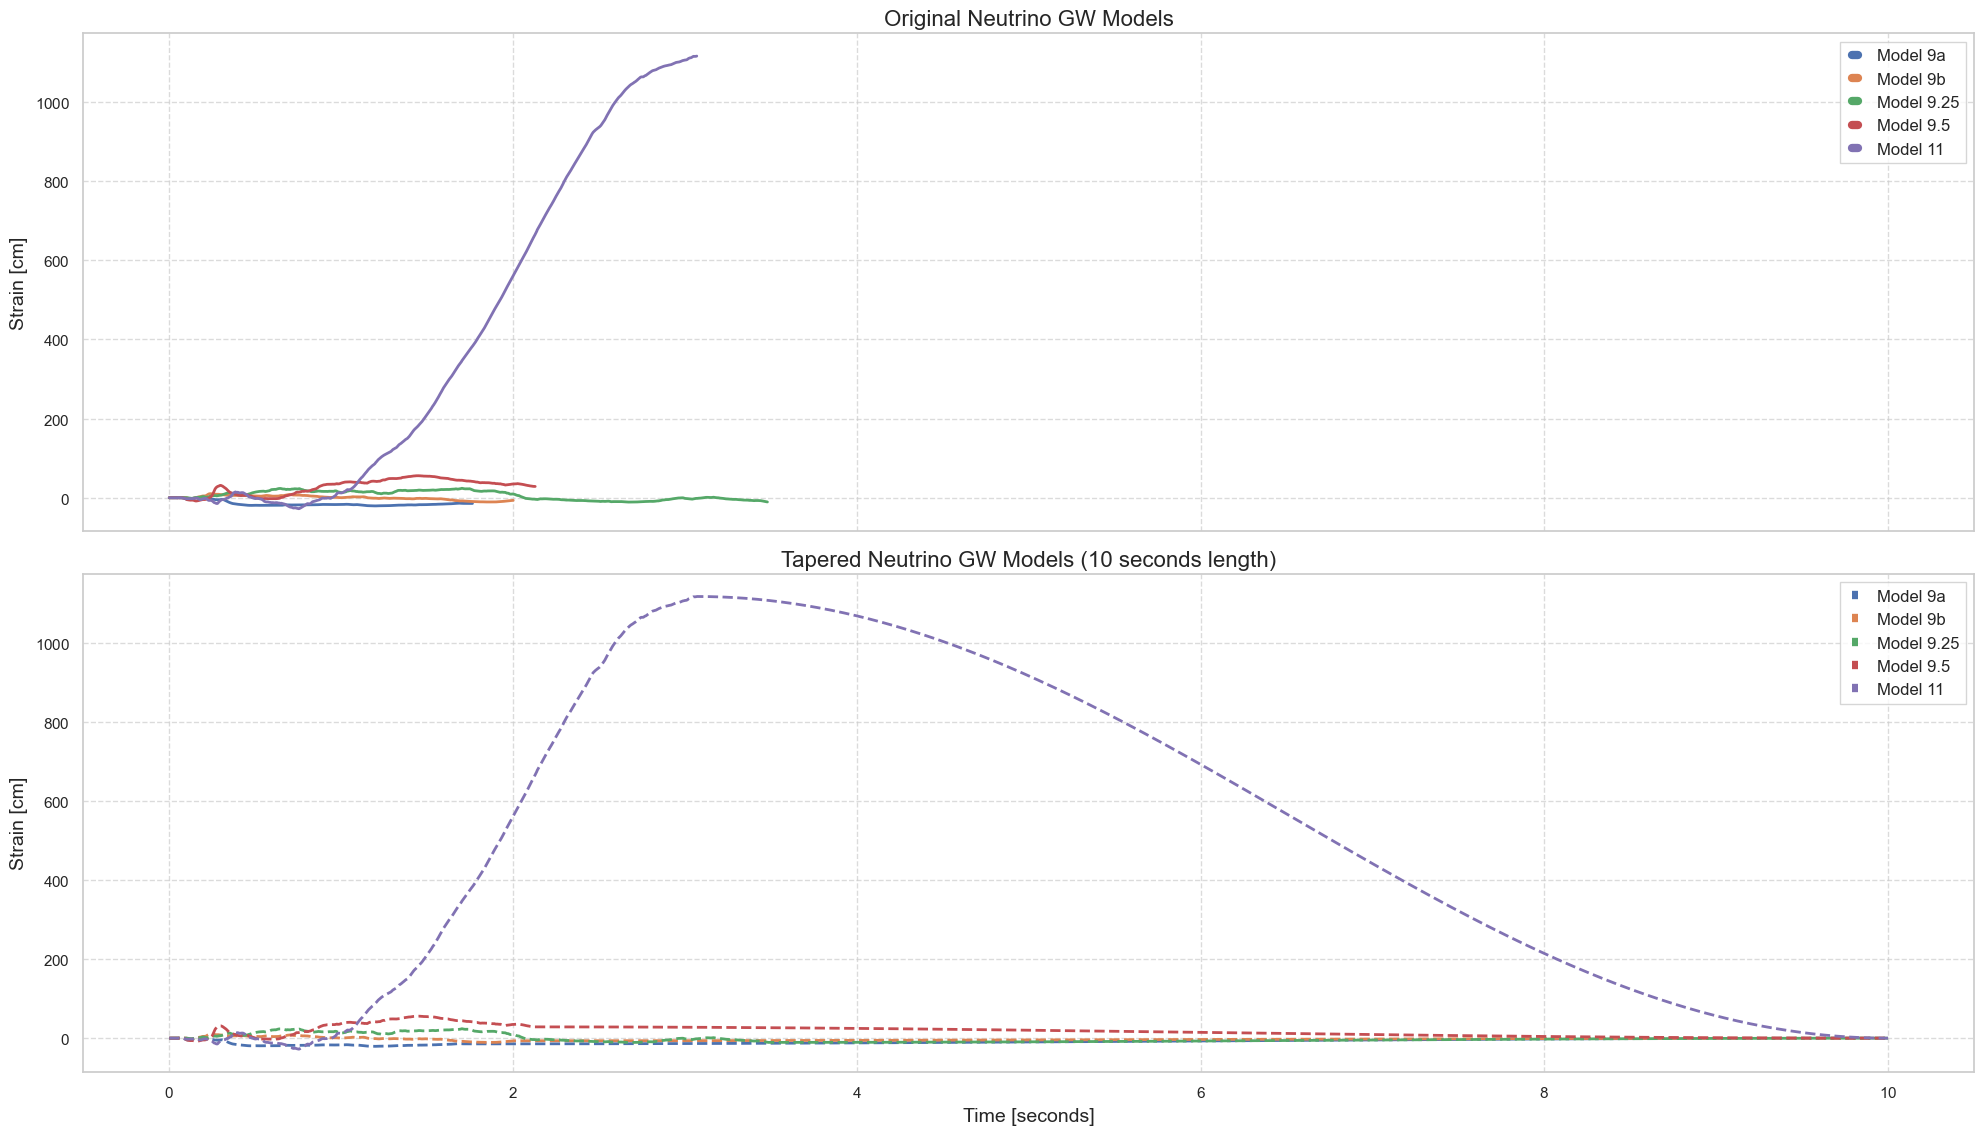

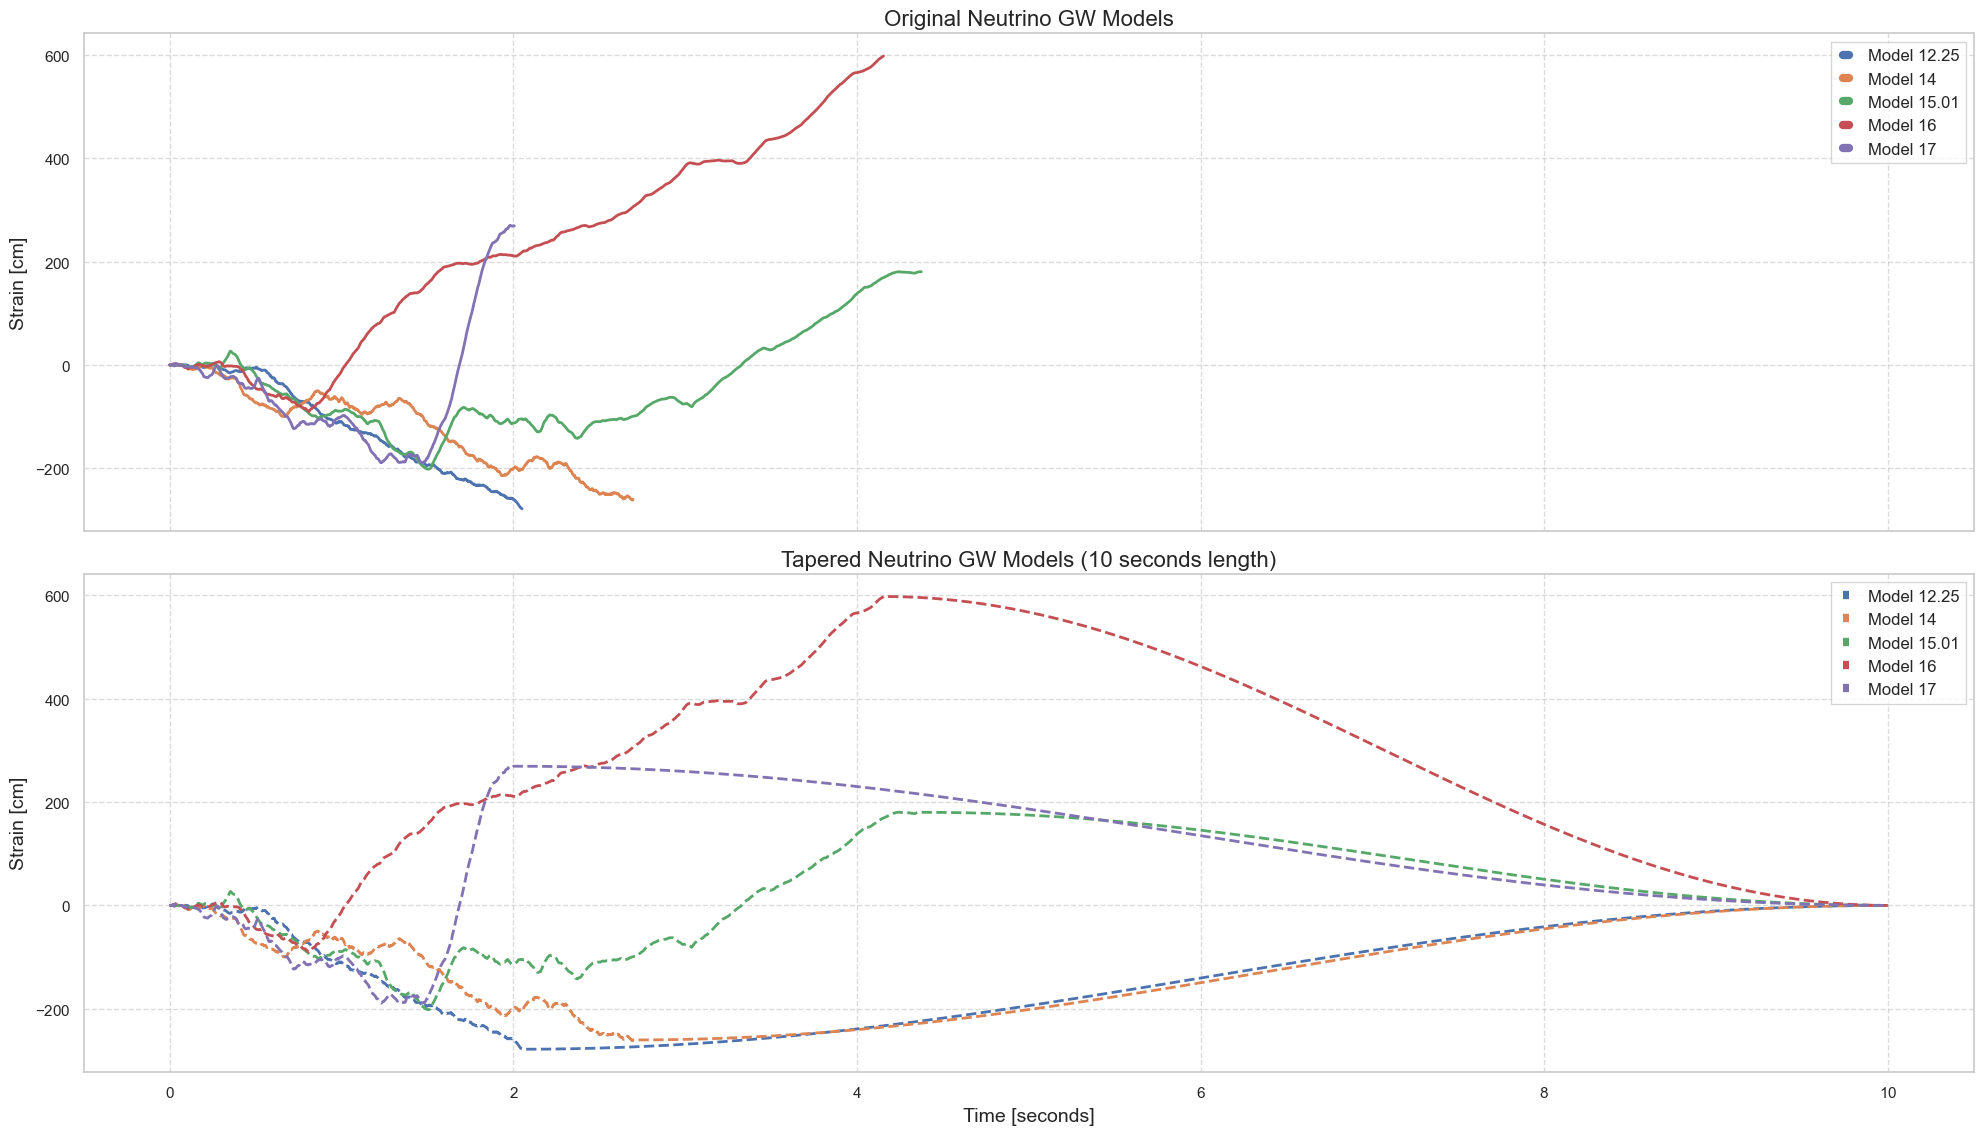

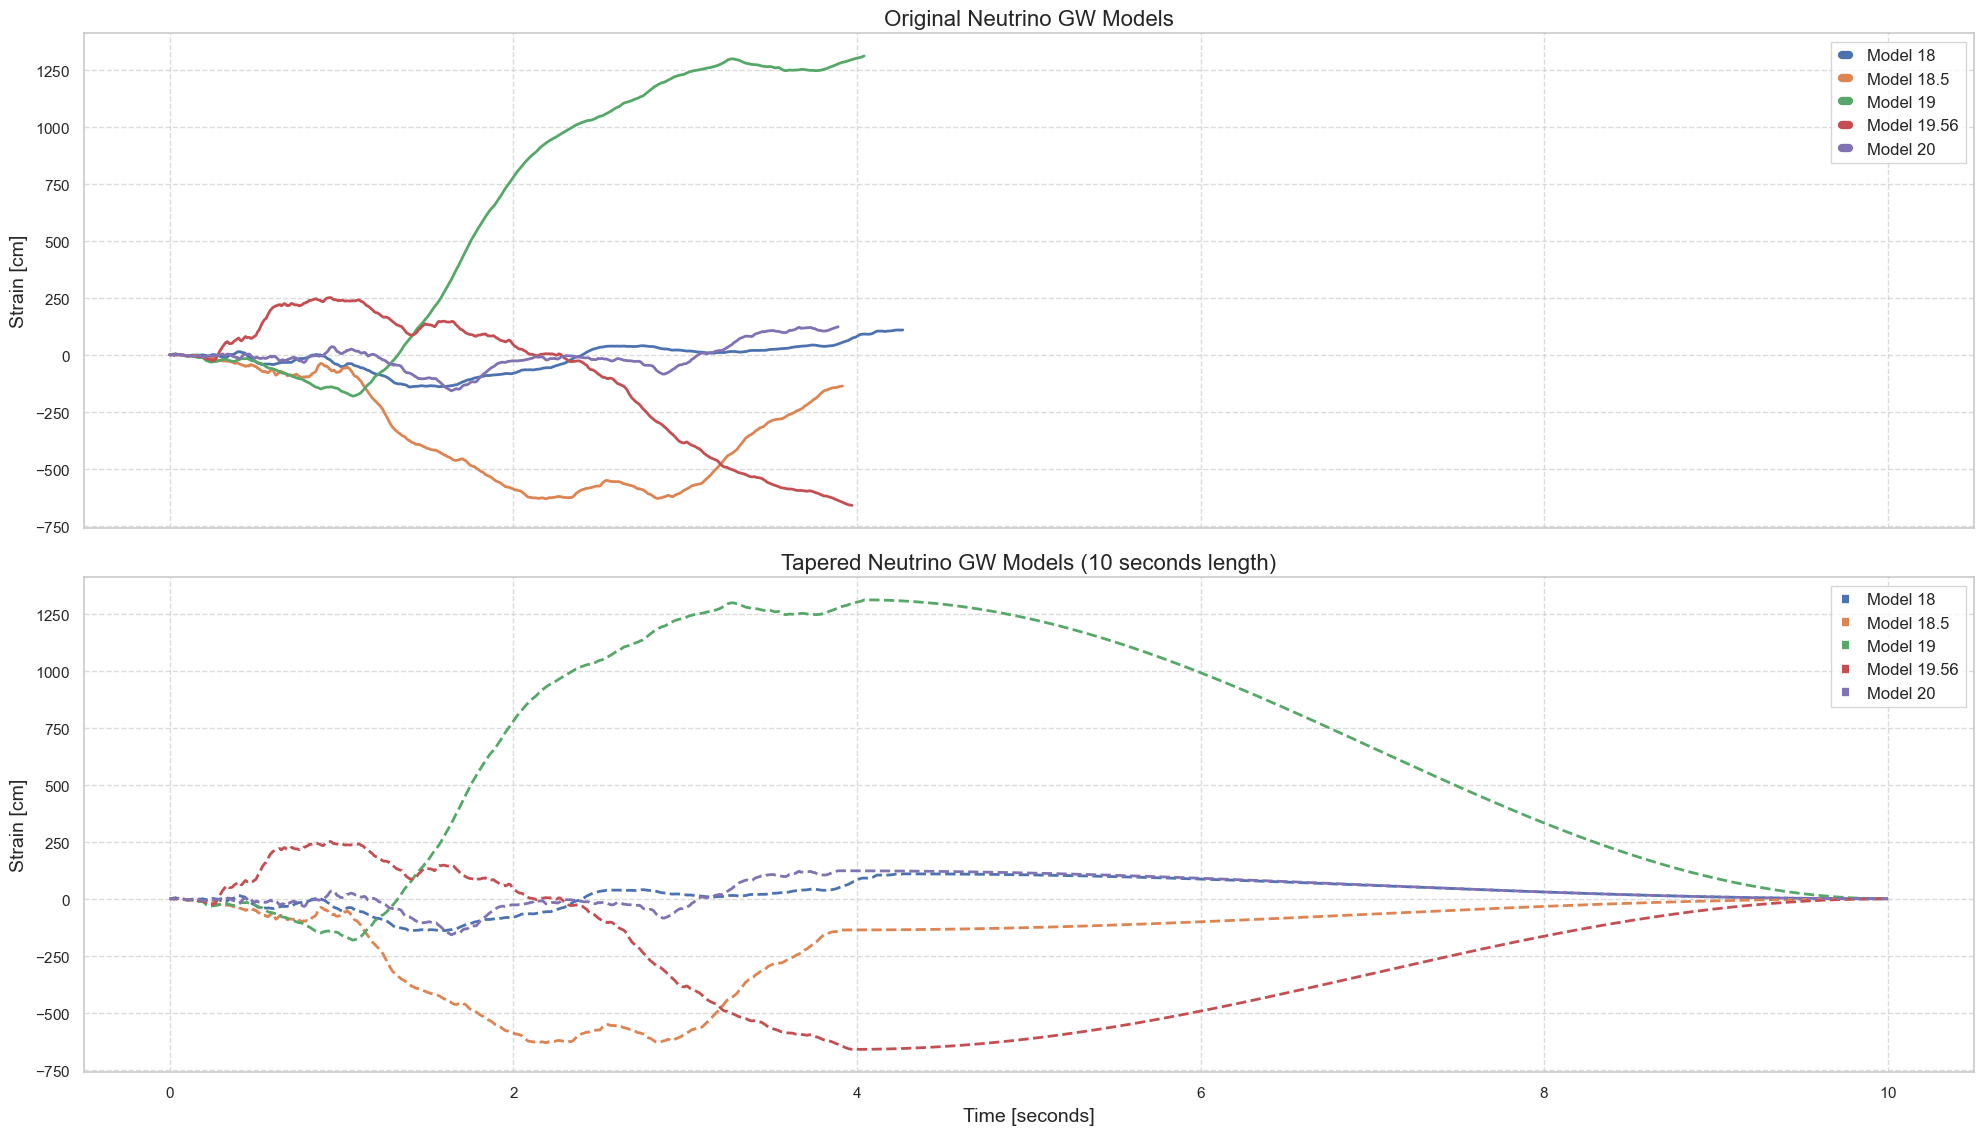

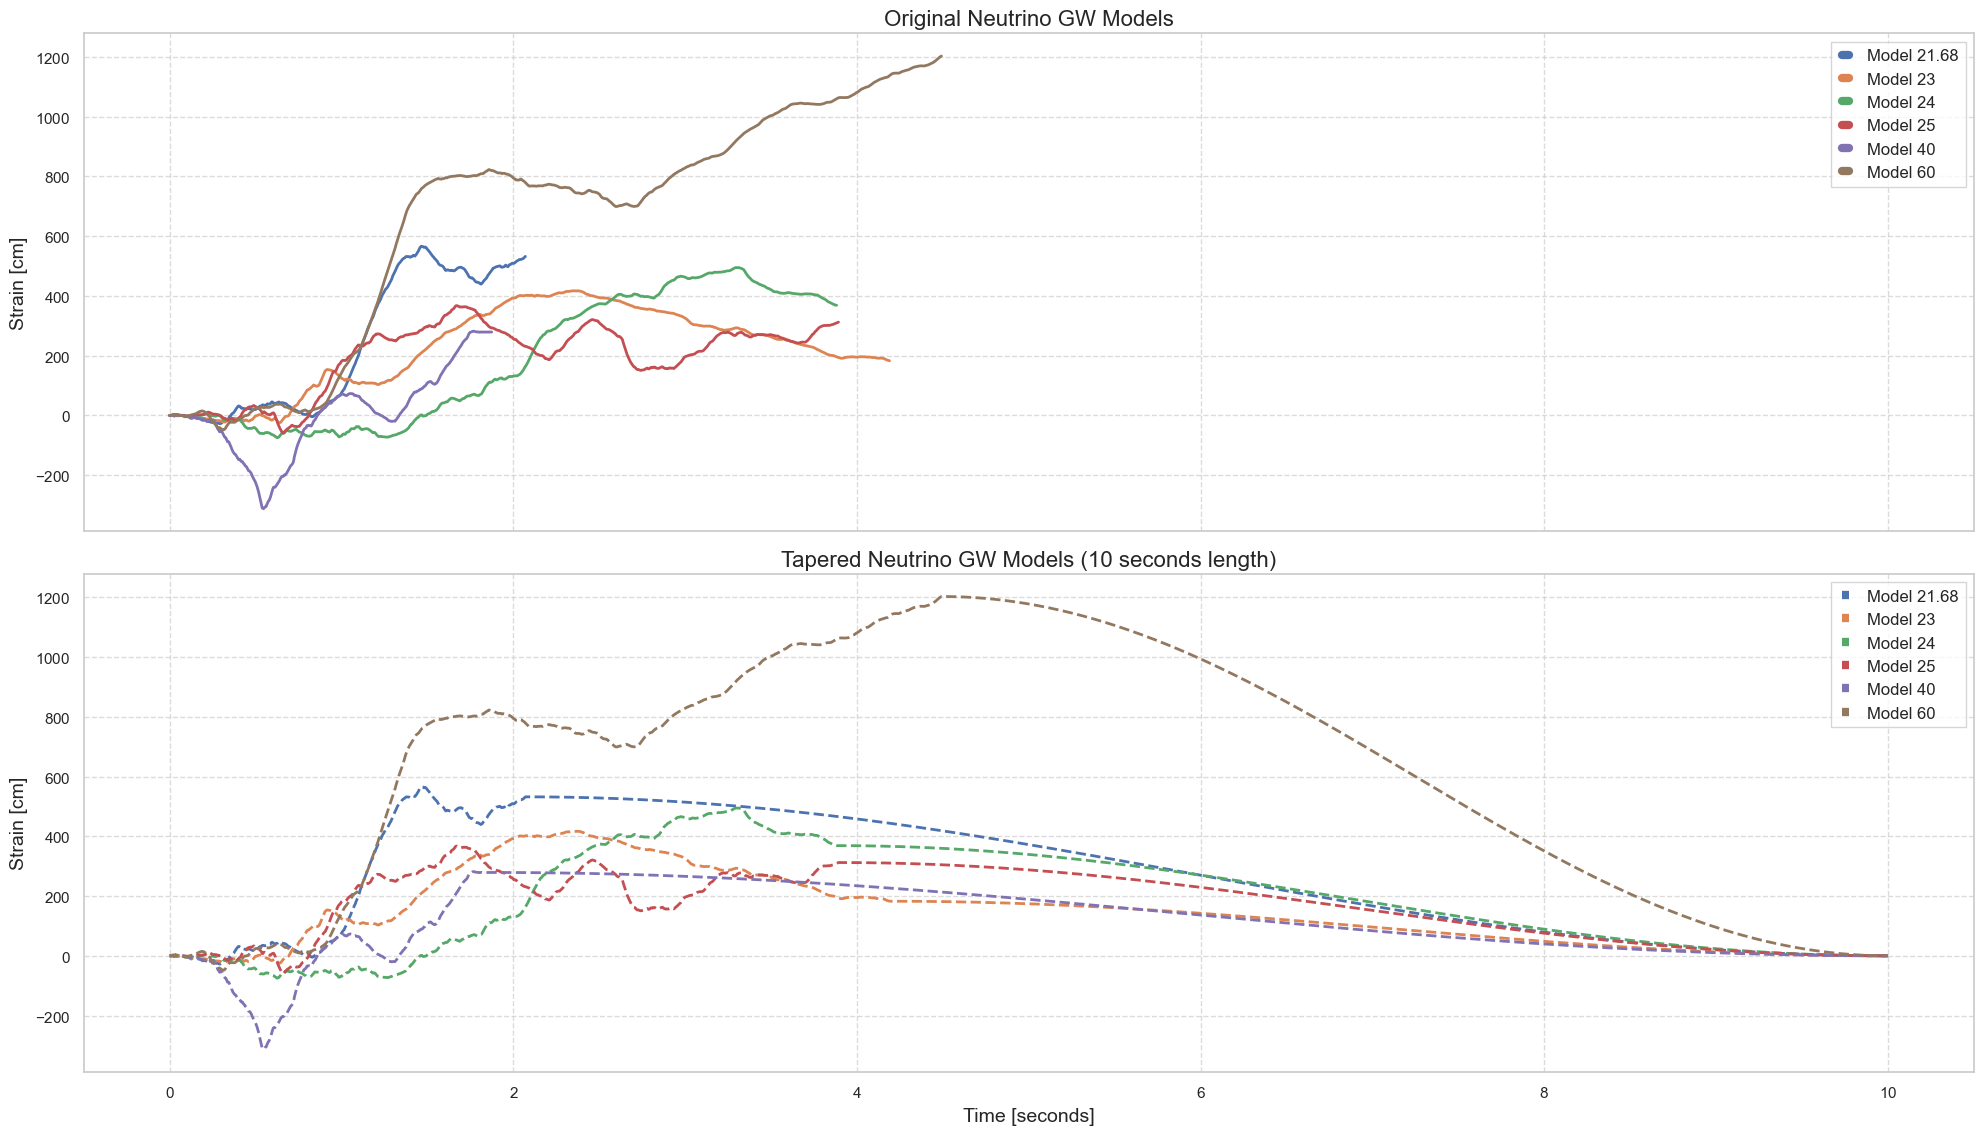

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Define model groups
model_groups = [
    ['9a', '9b', '9.25', '9.5', '11'],
    ['12.25', '14', '15.01', '16', '17'],
    ['18', '18.5', '19', '19.56', '20'],
    ['21.68', '23', '24', '25', '40', '60']
]

# Plot each group of Neutrino models
for models in model_groups:
    fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
    
    # Track plotted models to avoid duplication
    plotted_models = set()
    
    for model in models:
        # Ensure that each model is only plotted once
        if model not in plotted_models:
            try:
                original_data = input_models_neutrino[model]
                tapered_data = tapered_models_neutrino[model]

                # Plot original waveforms
                ax[0].plot(original_data['time'], original_data['strain'], label=f'Model {model}', linestyle='-', linewidth=2)

                # Plot tapered waveforms
                ax[1].plot(tapered_data['time'], tapered_data['strain'], label=f'Model {model}', linestyle='--', linewidth=2)

                # Mark this model as plotted
                plotted_models.add(model)
            except KeyError:
                print(f"Data for model {model} not found in dictionaries.")
                continue

    # Customize original waveform plot
    ax[0].set_ylabel('Strain [cm]', fontsize=14)
    ax[0].set_title('Original Neutrino GW Models', fontsize=16)
    ax[0].grid(True, linestyle='--', alpha=0.7)
    ax[0].legend(loc="upper right", fontsize=12)

    # Customize tapered waveform plot
    ax[1].set_xlabel('Time [seconds]', fontsize=14)
    ax[1].set_ylabel('Strain [cm]', fontsize=14)
    ax[1].set_title('Tapered Neutrino GW Models (10 seconds length)', fontsize=16)
    ax[1].grid(True, linestyle='--', alpha=0.7)
    ax[1].legend(loc="upper right", fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.show()


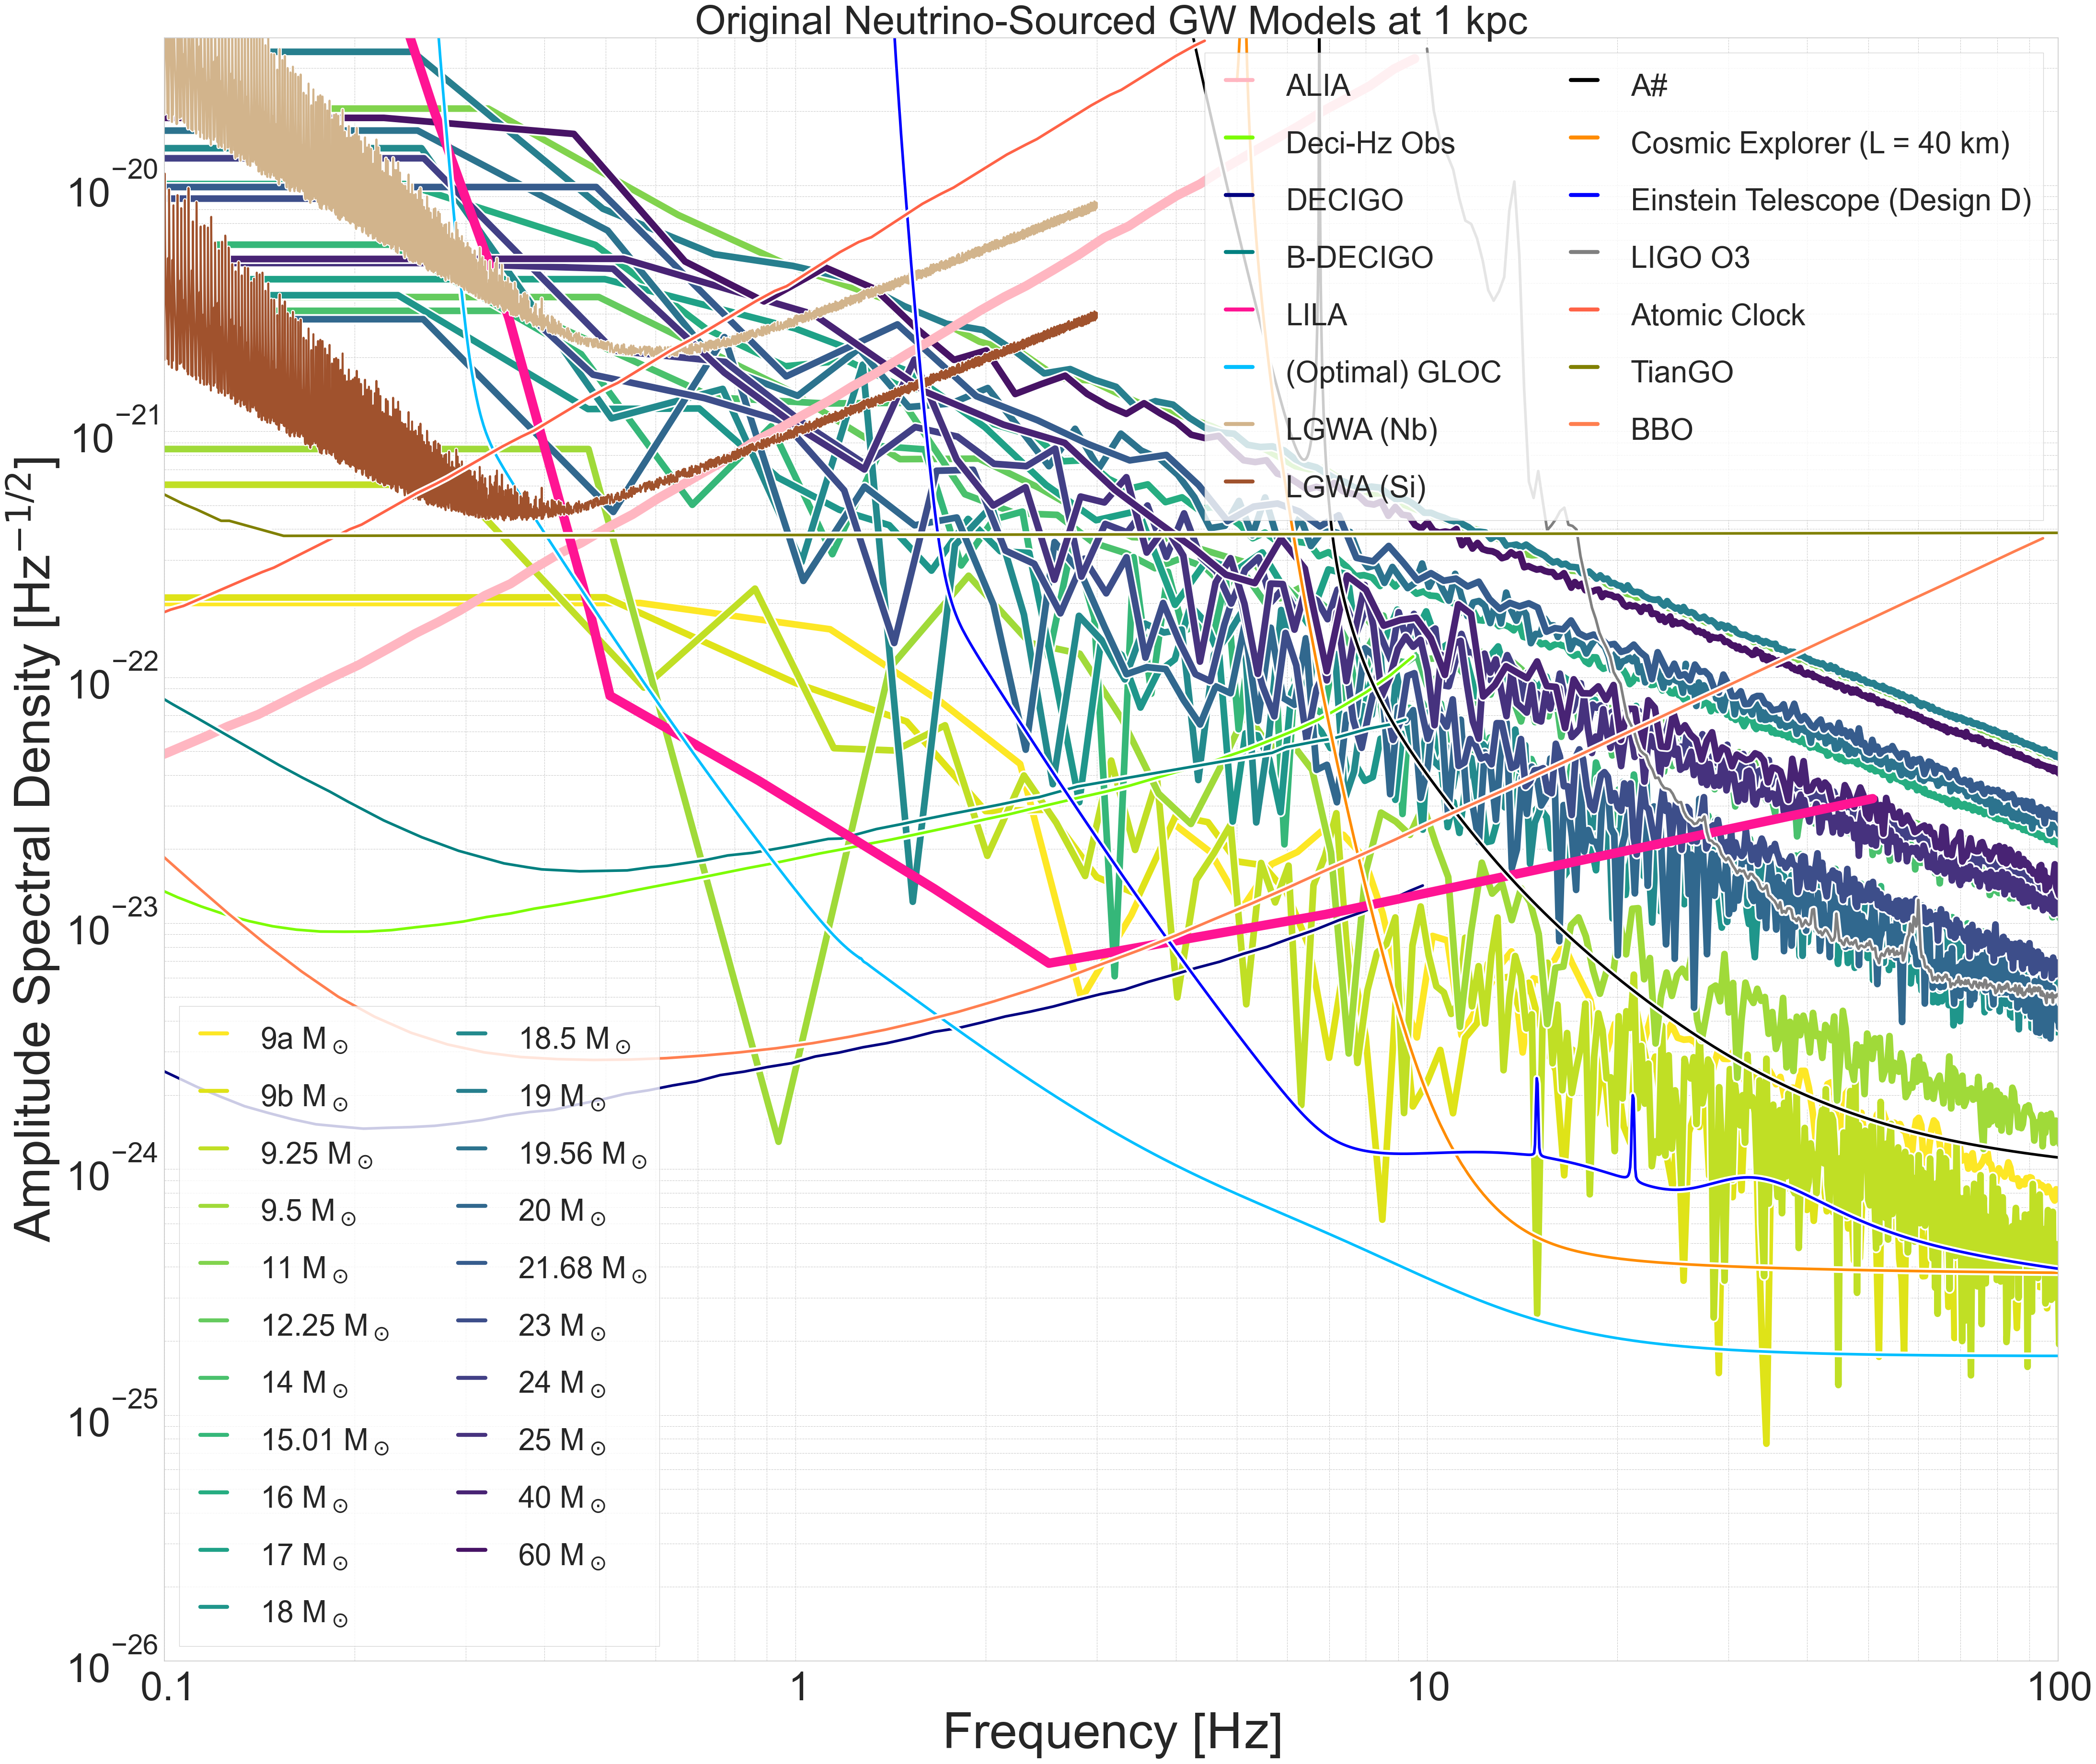

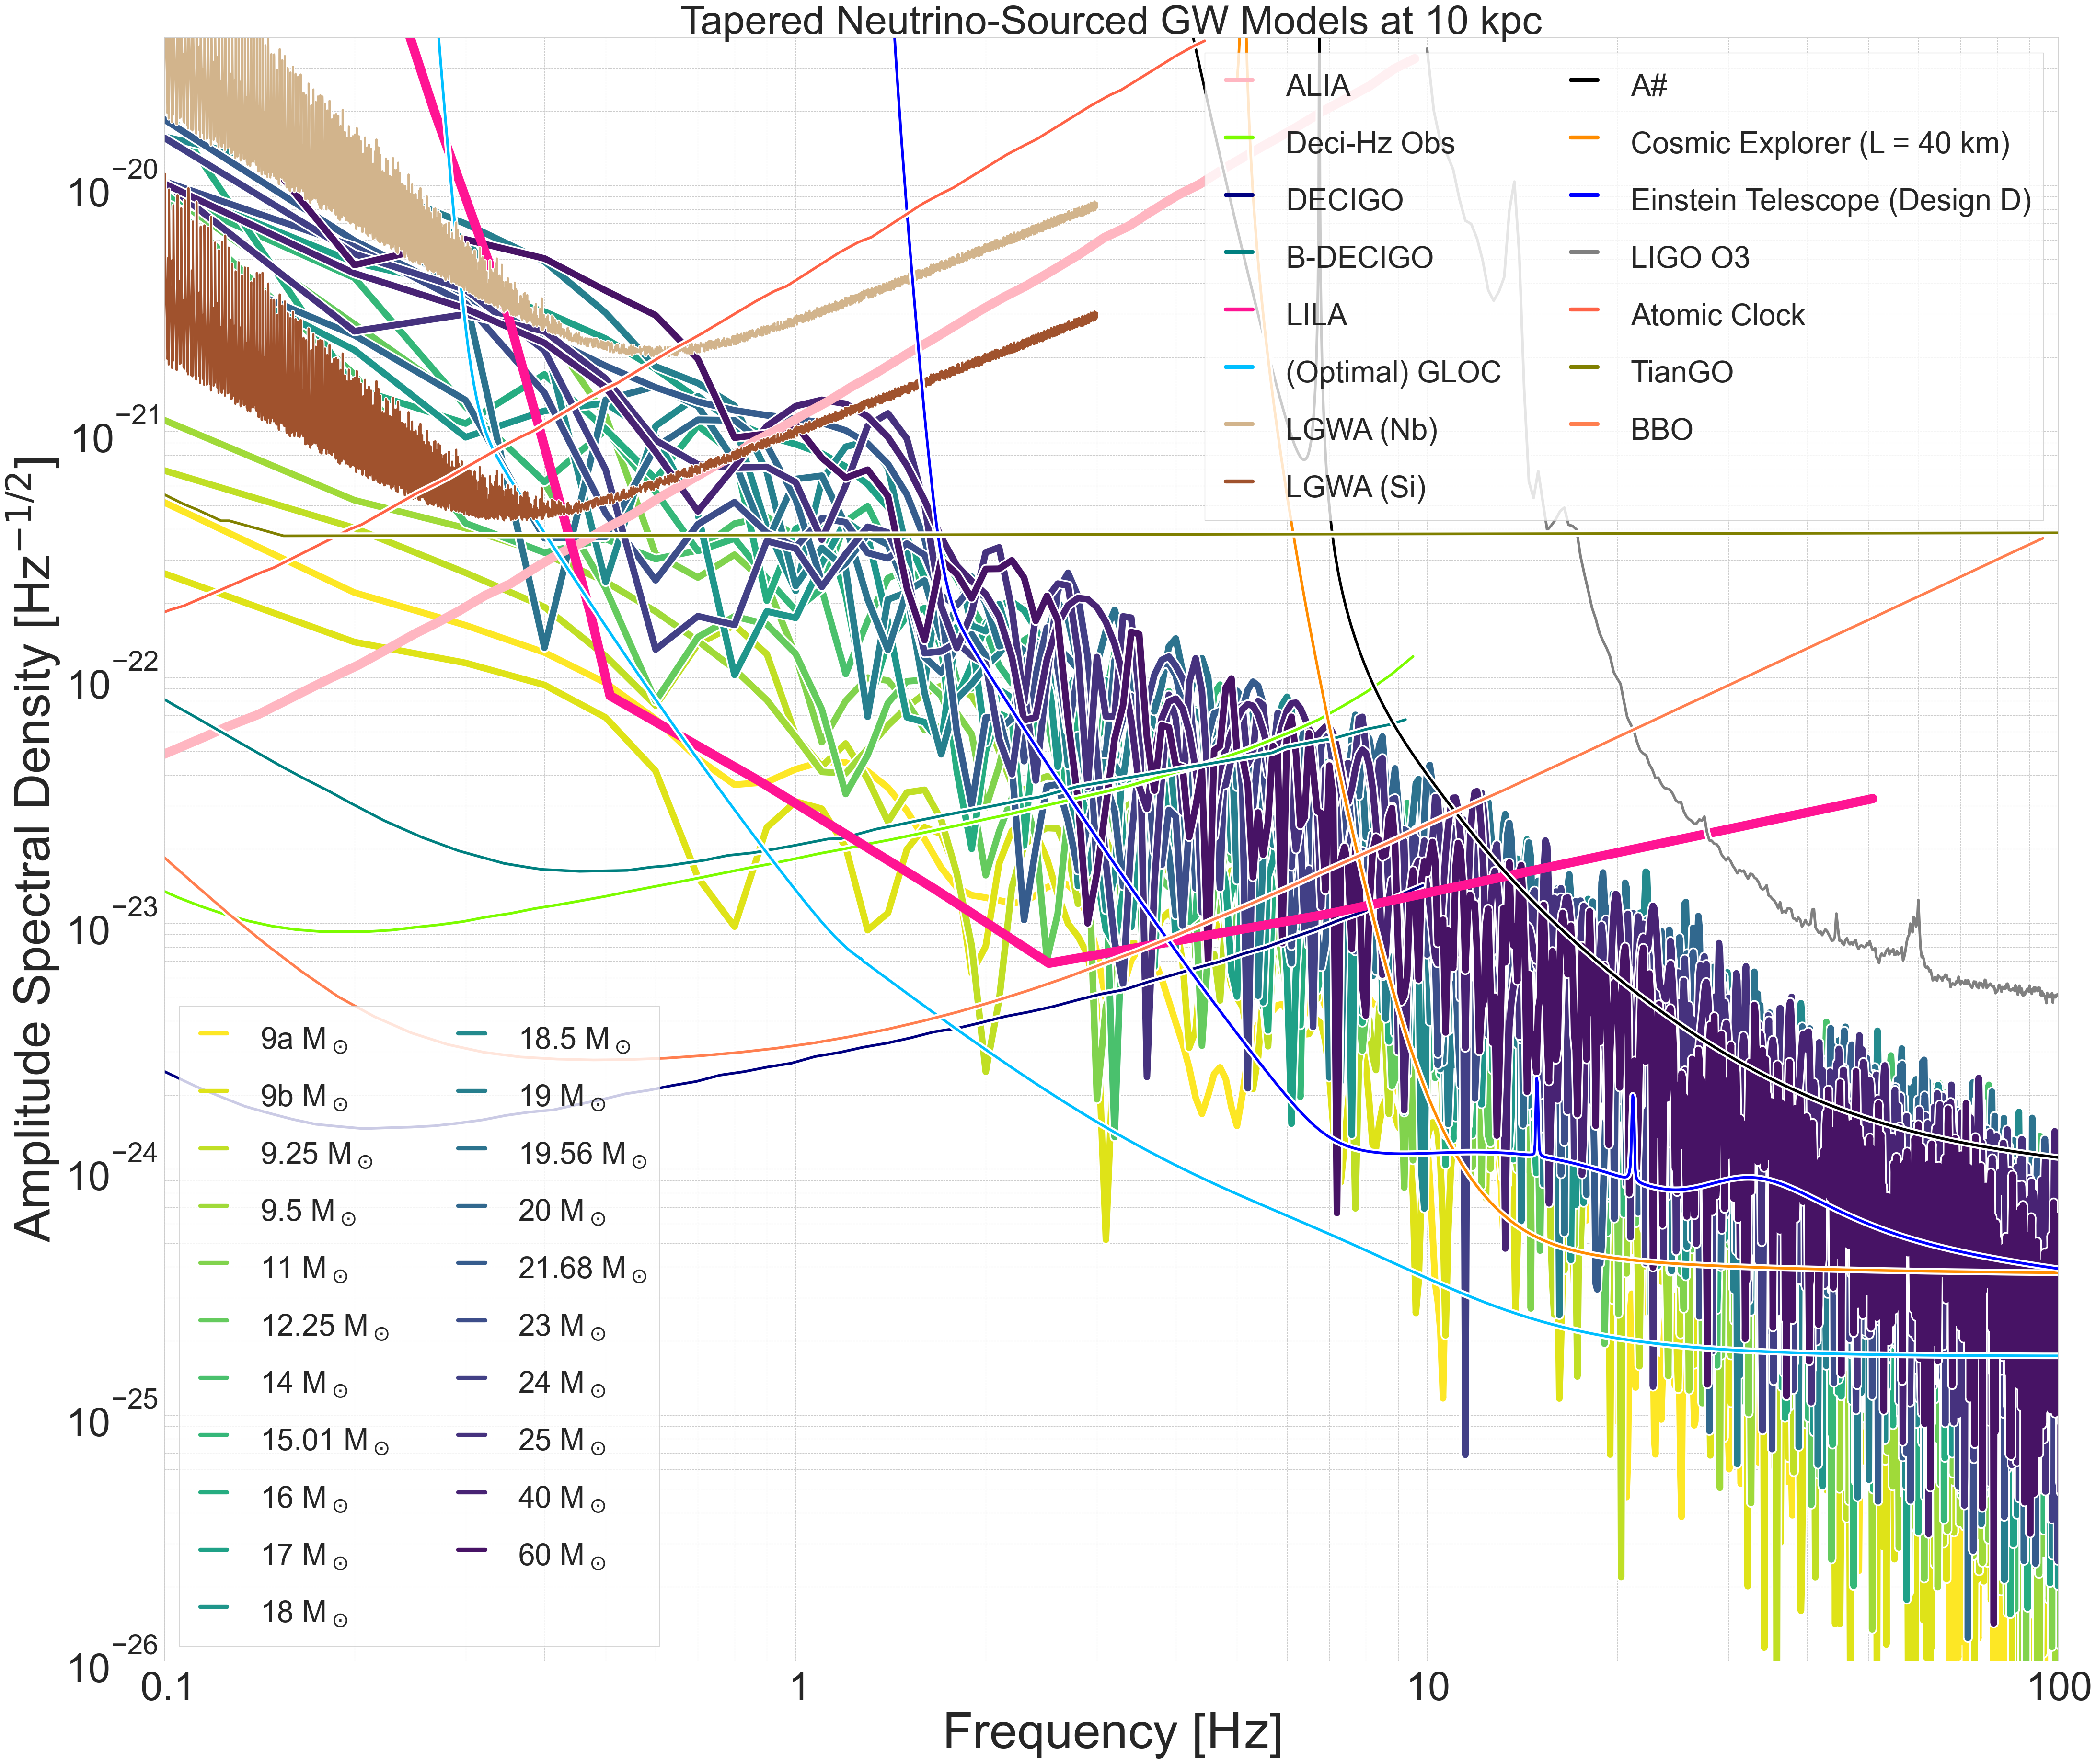

In [8]:

models = ['9a', '9b', '9.25', '9.5', '11', '12.25', '14', '15.01', '16', '17', '18', '18.5', '19', '19.56', '20', '21.68', '23', '24', '25', '40', '60']

# Plot original Neutrino GW strains against various GW detector PSDs
fig, ax = plt.subplots(figsize=(51, 44))
try:
    final_curves = plot_waveforms(
        models,
        *model_list(input_models_neutrino, var1='freq', var2='psd'),
        ax,
        cmap=plt.cm.viridis_r
    )
    sensitivity_curves = plot_sensitivity_curves(ax)
    style_plot(ax, legends=[sensitivity_curves, final_curves])
    ax.set_title('Original Neutrino-Sourced GW Models at 1 kpc', fontsize=60)
except Exception as e:
    print(f"Error plotting original Neutrino GW strains: {e}")
plt.show()

# Plot tapered Neutrino GW strains against various GW detector PSDs
fig, ax = plt.subplots(figsize=(51, 44))
try:
    final_curves = plot_waveforms(
        models,
        *model_list(final_models_neutrino, var1='freq', var2='psd'),
        ax,
        cmap=plt.cm.viridis_r
    )
    sensitivity_curves = plot_sensitivity_curves(ax)
    style_plot(ax, legends=[sensitivity_curves, final_curves])
    ax.set_title('Tapered Neutrino-Sourced GW Models at 10 kpc', fontsize=60)
except Exception as e:
    print(f"Error plotting tapered Neutrino GW strains: {e}")
plt.show()